# evaluate the enformer type models

In [1]:
#first let's load in the test data
import sys
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
import src.dataloaders.datasets.enformer_dataset as enformer_dataset
dataset = enformer_dataset.EnformerDataset('test', 160_000, rc_aug = False, load_into_memory=True)

In [2]:
#now we can load in the model and evaluate the data
print(dataset.labels.shape)

(1937, 896, 5313)


In [3]:
for i in dataset:
    2
print(i[0].shape)
print(i[1].shape)
#like half a second to load it all if it's in memory...

torch.Size([160000])
torch.Size([896, 4675])


In [4]:
dataset.labels.nbytes/1e9 #actually 37 GB!

36.883951104

In [5]:
#now we can load in the model and evaluate the data
import yaml
cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/enformer.yaml'
cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)

In [6]:
train_cfg = cfg['train']  # grab section `train` section of config
model_cfg = cfg['model_config']  # grab the `model` section of config
d_output = train_cfg['d_output']  #TODO make it so that we just adjust this with self.classificaiton, no need for evals
print(d_output, model_cfg, train_cfg)

1 {'_name_': 'dna_embedding', 'd_model': 256, 'n_layer': 8, 'd_inner': 1024, 'vocab_size': 16, 'resid_dropout': 0.0, 'embed_dropout': 0.1, 'fused_mlp': False, 'fused_dropout_add_ln': False, 'residual_in_fp32': True, 'pad_vocab_size_multiple': 1, 'return_hidden_state': True, 'layer': {'_name_': 'hyena', 'emb_dim': 5, 'filter_order': 64, 'local_order': 3, 'l_max': 160002, 'modulate': True, 'w': 10, 'lr': '6e-4', 'wd': 0.0, 'lr_pos_emb': 0.0}, 'bidirectional': False} {'d_output': 1}


In [7]:
ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-07-06/14-21-57-902384/checkpoints/01-val_loss=0.79042.ckpt'
from src.models.sequence.dna_embedding import DNAEmbeddingModel
from src.tasks.decoders import EnformerDecoder
import torch
backbone = DNAEmbeddingModel(**model_cfg)
decoder = EnformerDecoder(model_cfg['d_model'], l_output=0, mode='pool', d_output=4675)
state_dict = torch.load(ckpt_path, map_location='cpu')

In [8]:
decoder

EnformerDecoder(
  (output_transform): Linear(in_features=256, out_features=4675, bias=True)
  (pool): AvgPool1d(kernel_size=(128,), stride=(128,), padding=(0,))
)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    state_dict["state_dict"], "model."
)
model_state_dict = state_dict["state_dict"]
model_state_dict.keys()

odict_keys(['decoder.0.output_transform.weight', 'decoder.0.output_transform.bias', 'backbone.embeddings.word_embeddings.weight', 'backbone.layers.0.mixer.filter_fn.bias', 'backbone.layers.0.mixer.filter_fn.implicit_filter.0.bias', 'backbone.layers.0.mixer.filter_fn.implicit_filter.0.weight', 'backbone.layers.0.mixer.filter_fn.implicit_filter.1.freq', 'backbone.layers.0.mixer.filter_fn.implicit_filter.2.bias', 'backbone.layers.0.mixer.filter_fn.implicit_filter.2.weight', 'backbone.layers.0.mixer.filter_fn.implicit_filter.3.freq', 'backbone.layers.0.mixer.filter_fn.implicit_filter.4.bias', 'backbone.layers.0.mixer.filter_fn.implicit_filter.4.weight', 'backbone.layers.0.mixer.filter_fn.implicit_filter.5.freq', 'backbone.layers.0.mixer.filter_fn.implicit_filter.6.weight', 'backbone.layers.0.mixer.filter_fn.modulation.deltas', 'backbone.layers.0.mixer.filter_fn.pos_emb.t', 'backbone.layers.0.mixer.filter_fn.pos_emb.z', 'backbone.layers.0.mixer.in_proj.bias', 'backbone.layers.0.mixer.in_pro

In [10]:

# need to remove torchmetrics. to remove keys, need to convert to list first
for key in list(model_state_dict.keys()):
    if "torchmetrics" in key:
        model_state_dict.pop(key)
# the state_dict keys slightly mismatch from Lightning..., so we fix it here
decoder_state_dict = {}
decoder_state_dict['output_transform.weight'] = model_state_dict.pop('decoder.0.output_transform.weight')
decoder_state_dict['output_transform.bias'] = model_state_dict.pop('decoder.0.output_transform.bias')
# decoder_state_dict['output_transform_profile.weight'] = model_state_dict.pop('decoder.0.output_transform_profile.weight')
# decoder_state_dict['output_transform_profile.bias'] = model_state_dict.pop('decoder.0.output_transform_profile.bias')

In [11]:
decoder.load_state_dict(decoder_state_dict, strict=True)
backbone.load_state_dict(model_state_dict, strict=True)
decoder = decoder.to(device).eval()
backbone = backbone.to(device).eval()

In [14]:
#now we can evaluate the entire test set!
from tqdm import tqdm
#make output the same shape as labels
output = torch.zeros(dataset.labels.shape)
output = output[:,:,:4675]
with torch.no_grad():
    idx = 0
    for i in tqdm(dataset):
        x, y = i
        x = x.to(device).unsqueeze(0)
        y = y.to(device).unsqueeze(0)
        out,_ = backbone(x)
        out = decoder(out)
        #and assign it
        output[idx] = out.cpu().detach().squeeze(0)
        idx += 1
        # print(out.shape)
        # print(y.shape)
        # break

: 

In [12]:
#let's instead just run it here
#just look at a single example!
with torch.no_grad():
    x, y = dataset[0]
    x = x.to(device).unsqueeze(0)
    y = y.to(device).unsqueeze(0)
    out,_ = backbone(x)
    out = decoder(out)
    print(out.shape)
    print(y.shape)

torch.Size([1, 896, 4675])
torch.Size([1, 896, 4675])


In [13]:
#now let's look at this example!
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#first of all turn to numpy
out = out.cpu().detach().squeeze(0).numpy()
y = y.cpu().detach().squeeze(0).numpy()

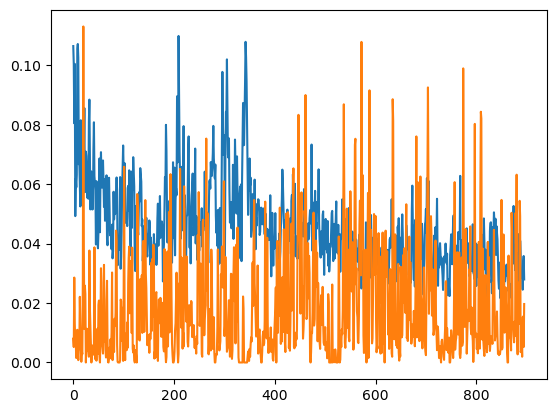

In [16]:
#now let's plot one of the tracks, the k562 track
#index 121 seems good!
plt.plot(np.exp(out[:,121]))
plt.plot(y[:,121])

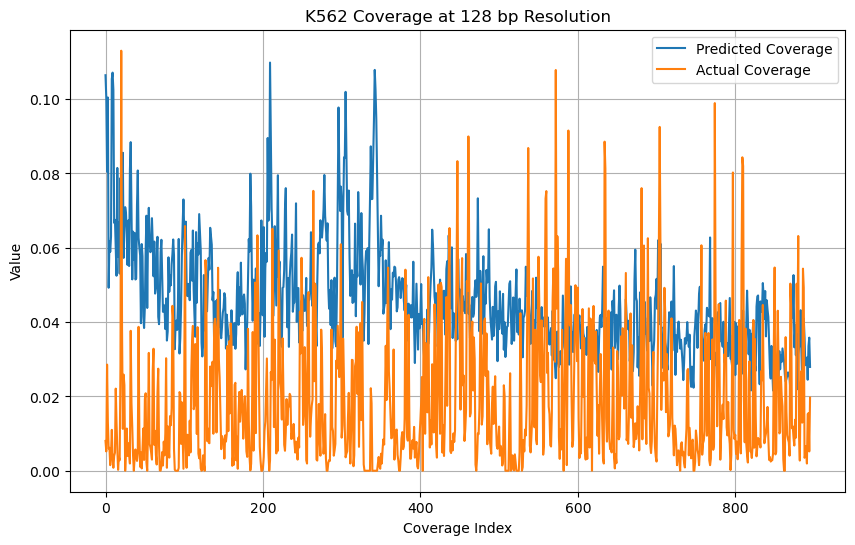

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(np.exp(out[:, 121]), label='Predicted Coverage')
plt.plot(y[:, 121], label='Actual Coverage')

# Adding title and labels
plt.title('K562 Coverage at 128 bp Resolution')
plt.xlabel('Coverage Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

torch.Size([1, 896, 4675])
torch.Size([1, 896, 4675])


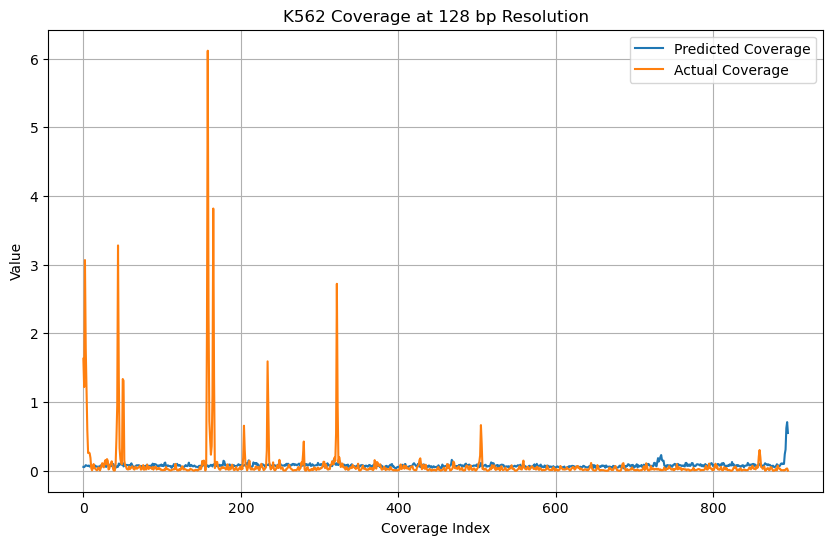

In [19]:
#the next data point
with torch.no_grad():
    x, y = dataset[1]
    x = x.to(device).unsqueeze(0)
    y = y.to(device).unsqueeze(0)
    out,_ = backbone(x)
    out = decoder(out)
    print(out.shape)
    print(y.shape)
#and plot
out = out.cpu().detach().squeeze(0).numpy()
y = y.cpu().detach().squeeze(0).numpy()
plt.figure(figsize=(10, 6))
plt.plot(np.exp(out[:, 121]), label='Predicted Coverage')
plt.plot(y[:, 121], label='Actual Coverage')

# Adding title and labels
plt.title('K562 Coverage at 128 bp Resolution')
plt.xlabel('Coverage Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)